M5 Forecasting - Accuracy

Note: This is one of the two complementary competitions that together comprise the M5 forecasting challenge. Can you estimate, as precisely as possible, the point forecasts of the unit sales of various products sold in the USA by Walmart?

How much camping gear will one store sell each month in a year? To the uninitiated, calculating sales at this level may seem as difficult as predicting the weather. Both types of forecasting rely on science and historical data. While a wrong weather forecast may result in you carrying around an umbrella on a sunny day, inaccurate business forecasts could result in actual or opportunity losses. In this competition, in addition to traditional forecasting methods you’re also challenged to use machine learning to improve forecast accuracy.

The Makridakis Open Forecasting Center (MOFC) at the University of Nicosia conducts cutting-edge forecasting research and provides business forecast training. It helps companies achieve accurate predictions, estimate the levels of uncertainty, avoiding costly mistakes, and apply best forecasting practices. The MOFC is well known for its Makridakis Competitions, the first of which ran in the 1980s.

In this competition, the fifth iteration, you will use hierarchical sales data from Walmart, the world’s largest company by revenue, to forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy.

If successful, your work will continue to advance the theory and practice of forecasting. The methods used can be applied in various business areas, such as setting up appropriate inventory or service levels. Through its business support and training, the MOFC will help distribute the tools and knowledge so others can achieve more accurate and better calibrated forecasts, reduce waste and be able to appreciate uncertainty and its risk implications.

Evaluation:
This competition uses a Weighted Root Mean Squared Scaled Error (RMSSE). Extensive details about the metric, scaling, and weighting can be found in the [M5 Participants Guide](https://mofc.unic.ac.cy/m5-competition/).

In [1]:
import gc
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima_model import ARIMA

pd.options.display.max_columns = 92

In [2]:
'''
Function to reduce memory usage.
From: https://www.kaggle.com/ragnar123/very-fst-model
'''
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
#Creates dummies
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name], prefix = column_name)
    df = pd.concat([df, dummies], axis = 1)
    return df

In [4]:
#Load data.
calendar = pd.read_csv('calendar.csv')
calendar = reduce_mem_usage(calendar)

#verify how many weeks do we have. This will help us to analise the prices.
print('weeks: ', len(calendar['wm_yr_wk'].drop_duplicates()))
print()

#Verify null
print('Verify null:')
print(calendar.isnull().sum())
print()
print(calendar.isnull().sum() / len(calendar))
print()


#Verify holidays
event_name_1 = calendar['event_name_1'].value_counts(dropna = False) #30
event_type_1 = calendar['event_type_1'].value_counts(dropna = False) #4
event_name_2 = calendar['event_name_2'].value_counts(dropna = False) #4
event_type_2 = calendar['event_type_2'].value_counts(dropna = False) #2


#Verify snap
snap_CA = calendar['snap_CA'].value_counts(dropna = False) #49.28% are snap days
snap_TX = calendar['snap_TX'].value_counts(dropna = False)
snap_WI = calendar['snap_WI'].value_counts(dropna = False)


print('event_name_1:')
print('')
display(event_name_1)
print('')
print('event_type_1:')
print('')
display(event_type_1)
print('')
print('event_name_2:')
print('')
display(event_name_2)
print('')
print('event_type_2:')
print('')
display(event_type_2)
print('')
print('snap_CA:')
print('')
display(snap_CA)
print('')
print('snap_TX:')
print('')
display(snap_TX)
print('')
print('snap_WI:')
print('')
display(snap_WI)

display(calendar.head())
display(calendar.tail())

Mem. usage decreased to  0.12 Mb (41.9% reduction)
weeks:  282

Verify null:
date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

date            0.000000
wm_yr_wk        0.000000
weekday         0.000000
wday            0.000000
month           0.000000
year            0.000000
d               0.000000
event_name_1    0.917725
event_type_1    0.917725
event_name_2    0.997461
event_type_2    0.997461
snap_CA         0.000000
snap_TX         0.000000
snap_WI         0.000000
dtype: float64

event_name_1:



NaN                    1807
ValentinesDay             6
Purim End                 6
Mother's day              6
Pesach End                6
SuperBowl                 6
StPatricksDay             6
LentWeek2                 6
LentStart                 6
NBAFinalsStart            6
NBAFinalsEnd              6
MemorialDay               6
Ramadan starts            6
PresidentsDay             6
VeteransDay               5
Halloween                 5
OrthodoxChristmas         5
ColumbusDay               5
Christmas                 5
IndependenceDay           5
EidAlAdha                 5
Chanukah End              5
Cinco De Mayo             5
NewYear                   5
Easter                    5
OrthodoxEaster            5
LaborDay                  5
Thanksgiving              5
Eid al-Fitr               5
MartinLutherKingDay       5
Father's day              4
Name: event_name_1, dtype: int64


event_type_1:



NaN          1807
Religious      55
National       52
Cultural       37
Sporting       18
Name: event_type_1, dtype: int64


event_name_2:



NaN               1964
Father's day         2
Easter               1
Cinco De Mayo        1
OrthodoxEaster       1
Name: event_name_2, dtype: int64


event_type_2:



NaN          1964
Cultural        4
Religious       1
Name: event_type_2, dtype: int64


snap_CA:



0    1319
1     650
Name: snap_CA, dtype: int64


snap_TX:



0    1319
1     650
Name: snap_TX, dtype: int64


snap_WI:



0    1319
1     650
Name: snap_WI, dtype: int64

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


File 1: “calendar.csv”

Contains information about the dates the products are sold.

     date: The date in a “y-m-d” format.

     wm_yr_wk: The id of the week the date belongs to.
    
     weekday: The type of the day (Saturday, Sunday, …, Friday).
    
     wday: The id of the weekday, starting from Saturday.
    
     month: The month of the date.
    
     year: The year of the date.
    
     event_name_1: If the date includes an event, the name of this event.
    
     event_type_1: If the date includes an event, the type of this event.
    
     event_name_2: If the date includes a second event, the name of this event.
    
     event_type_2: If the date includes a second event, the type of this event.
    
     snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP2 purchases on the examined date. 1 indicates that SNAP purchases are allowed.

In [5]:
#make new time related variables

#Seasons
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['week_of_year'] = calendar['date'].dt.week
calendar['day'] = calendar['date'].dt.day

calendar['season'] = calendar.apply(lambda row: 'spring' if (row['month'] >= 3 and row['month'] <= 5)
                            else('summer' if (row['month'] >= 6 and row['month'] <= 8)
                            else('fall' if (row['month'] >= 9 and row['month'] <= 11)
                            else('winter'))), axis = 1)


calendar['month_fase'] = calendar.apply(lambda row: 'start' if (row['day'] <= 7)
                            else('middle' if (row['day'] >= 8 and row['day'] <= 21)
                            else('end')), axis = 1)

#Create dummies
#columns = ['season', 'month', 'wday', 'month_fase', 'event_name_1'
#                   , 'event_type_1', 'event_name_2', 'event_type_2']

#for col in columns:
#    calendar = create_dummies(calendar, col)

#calendar.drop(['season', 'month', 'wday', 'month_fase', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'], inplace = True, axis = 1)
    
    
#Verify if there is a snap sales in other state.
calendar['snap_other_CA'] = calendar.apply(lambda row: 1 if (row['snap_TX'] + row['snap_WI'] != 0)
                                          else 0, axis = 1)
calendar['snap_other_CA_only'] = calendar.apply(lambda row: 1 if (row['snap_TX'] + row['snap_WI'] != 0 and row['snap_CA'] != 1)
                                          else 0, axis = 1)

calendar['snap_other_TX'] = calendar.apply(lambda row: 1 if (row['snap_CA'] + row['snap_WI'] != 0)
                                          else 0, axis = 1)
calendar['snap_other_TX_only'] = calendar.apply(lambda row: 1 if (row['snap_CA'] + row['snap_WI'] != 0 and row['snap_TX'] != 1)
                                          else 0, axis = 1)

calendar['snap_other_WI'] = calendar.apply(lambda row: 1 if (row['snap_TX'] + row['snap_CA'] != 0)
                                          else 0, axis = 1)
calendar['snap_other_WI_only'] = calendar.apply(lambda row: 1 if (row['snap_TX'] + row['snap_CA'] != 0 and row['snap_WI'] != 1)
                                          else 0, axis = 1)

display(calendar.head())
display(calendar.tail())

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week_of_year,day,season,month_fase,snap_other_CA,snap_other_CA_only,snap_other_TX,snap_other_TX_only,snap_other_WI,snap_other_WI_only
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,4,29,winter,end,0,0,0,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,4,30,winter,end,0,0,0,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,5,31,winter,end,0,0,0,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,5,1,winter,start,1,0,1,0,1,1
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,5,2,winter,start,1,0,1,1,1,0


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week_of_year,day,season,month_fase,snap_other_CA,snap_other_CA_only,snap_other_TX,snap_other_TX_only,snap_other_WI,snap_other_WI_only
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1,24,15,summer,middle,1,1,1,0,1,0
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0,24,16,summer,middle,0,0,0,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0,24,17,summer,middle,0,0,0,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0,24,18,summer,middle,0,0,0,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,24,19,summer,middle,0,0,0,0,0,0


File 3: “sales_train.csv”

Contains the historical daily unit sales data per product and store.

     item_id: The id of the product.

     dept_id: The id of the department the product belongs to.

     cat_id: The id of the category the product belongs to.

     store_id: The id of the store where the product is sold.

     state_id: The State where the store is located.

     d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29.
    
    
We have 282 and 30,490 differents items. Therefore, the ideal would be to have 8,598,180 (282 x 30,400) prices. 

In [6]:
sell_prices = pd.read_csv('sell_prices.csv')
sell_prices = reduce_mem_usage(sell_prices)

print("len: ", len(sell_prices))
print()
#Verify null
print('Verify null:')
print(sell_prices.isnull().sum())
print()
print(sell_prices.isnull().sum() / len(sell_prices))
print()
display(sell_prices.head())
print()
display(sell_prices.tail())

Mem. usage decreased to 130.48 Mb (37.5% reduction)
len:  6841121

Verify null:
store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

store_id      0.0
item_id       0.0
wm_yr_wk      0.0
sell_price    0.0
dtype: float64



,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


,store_id,item_id,wm_yr_wk,sell_price
6841116,WI_3,FOODS_3_827,11617,1.0
6841117,WI_3,FOODS_3_827,11618,1.0
6841118,WI_3,FOODS_3_827,11619,1.0
6841119,WI_3,FOODS_3_827,11620,1.0
6841120,WI_3,FOODS_3_827,11621,1.0


File 2: “sell_prices.csv”

Contains information about the price of the products sold per store and date.

     store_id: The id of the store where the product is sold.

     item_id: The id of the product.

     wm_yr_wk: The id of the week.

     sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).
    
    
Considering that we have only 6,841,121 prices, there are  1,757,059 (8,598,180 - 6,841,121) products that were not sold in a given week.

In [7]:
#make new price related variables
# def create_bins_price_variation(df, var_name_in):
#     cut_points = [-999, -0.25, -0.15, -0.10, -0.05, -0.001, 0.05, 0.10, 0.15, 0.25, 999]
#     label_names = ["--0.25", "-0.25-0.15", "-0.15-0.10", "-0.10-0.5", "-0.05-0", "0-0.05", "0.05-0.10", "0.10-0.15", "0.15-0.25", "0.25++"]
#     df[var_name_in + '_bin'] = pd.cut(df[var_name_in], cut_points, labels = label_names)
#     #create dummy
#     df = create_dummies(df, var_name_in + '_bin')
#     df.drop([var_name_in, var_name_in + '_bin'], inplace = True, axis = 1)
#     return df

    
sell_prices['price_id'] = str(sell_prices['item_id'])+str(sell_prices['store_id'])

sell_prices['lag_price_t1'] = sell_prices.groupby(['price_id'])['sell_price'].transform(lambda x: x.shift(1))
sell_prices['price_change_t1'] = (sell_prices['sell_price'] - sell_prices['lag_price_t1']) / (sell_prices['lag_price_t1'])

#Create bins for price change
# sell_prices = create_bins_price_variation(sell_prices, 'price_change_t1')


sell_prices['rolling_price_max_t4'] = sell_prices.groupby(['item_id'])['sell_price'].transform(lambda x: x.shift(1).rolling(4).max())
sell_prices['rolling_price_max_t13'] = sell_prices.groupby(['item_id'])['sell_price'].transform(lambda x: x.shift(1).rolling(13).max())
sell_prices['rolling_price_max_t26'] = sell_prices.groupby(['item_id'])['sell_price'].transform(lambda x: x.shift(1).rolling(26).max())
sell_prices['rolling_price_max_t52'] = sell_prices.groupby(['item_id'])['sell_price'].transform(lambda x: x.shift(1).rolling(52).max())

sell_prices['price_change_max_t4'] = (sell_prices['sell_price'] - sell_prices['rolling_price_max_t4']) / (sell_prices['rolling_price_max_t4'])
sell_prices['price_change_max_t13'] = (sell_prices['sell_price'] - sell_prices['rolling_price_max_t13']) / (sell_prices['rolling_price_max_t13'])
sell_prices['price_change_max_t26'] = (sell_prices['sell_price'] - sell_prices['rolling_price_max_t26']) / (sell_prices['rolling_price_max_t26'])
sell_prices['price_change_max_t52'] = (sell_prices['sell_price'] - sell_prices['rolling_price_max_t52']) / (sell_prices['rolling_price_max_t52'])

#Create bins for max price change
# sell_prices = create_bins_price_variation(sell_prices, 'price_change_max_t4')
# sell_prices = create_bins_price_variation(sell_prices, 'price_change_max_t13')
# sell_prices = create_bins_price_variation(sell_prices, 'price_change_max_t26')
# sell_prices = create_bins_price_variation(sell_prices, 'price_change_max_t52')


sell_prices['rolling_price_std_t4'] = sell_prices.groupby(['price_id'])['sell_price'].transform(lambda x: x.rolling(4).std())
sell_prices['rolling_price_std_t13'] = sell_prices.groupby(['price_id'])['sell_price'].transform(lambda x: x.rolling(13).std())
sell_prices['rolling_price_std_t26'] = sell_prices.groupby(['price_id'])['sell_price'].transform(lambda x: x.rolling(26).std())
sell_prices['rolling_price_std_t52'] = sell_prices.groupby(['price_id'])['sell_price'].transform(lambda x: x.rolling(52).std())

sell_prices['rolling_price_mean_t4'] = sell_prices.groupby(['price_id'])['sell_price'].transform(lambda x: x.rolling(4).mean())
sell_prices['rolling_price_mean_t13'] = sell_prices.groupby(['price_id'])['sell_price'].transform(lambda x: x.rolling(13).mean())
sell_prices['rolling_price_mean_t26'] = sell_prices.groupby(['price_id'])['sell_price'].transform(lambda x: x.rolling(26).mean())
sell_prices['rolling_price_mean_t52'] = sell_prices.groupby(['price_id'])['sell_price'].transform(lambda x: x.rolling(52).mean())
                                                                                                  
sell_prices['price_change_mean_t4'] = (sell_prices['sell_price'] - sell_prices['rolling_price_mean_t4']) / (sell_prices['rolling_price_mean_t4'])
sell_prices['price_change_mean_t13'] = (sell_prices['sell_price'] - sell_prices['rolling_price_mean_t13']) / (sell_prices['rolling_price_mean_t13'])
sell_prices['price_change_mean_t26'] = (sell_prices['sell_price'] - sell_prices['rolling_price_mean_t26']) / (sell_prices['rolling_price_mean_t26'])                                                                                                   
sell_prices['price_change_mean_t52'] = (sell_prices['sell_price'] - sell_prices['rolling_price_mean_t52']) / (sell_prices['rolling_price_mean_t52'])                                                                                                    

#Create bins for mean price change                                                                                                  
# sell_prices = create_bins_price_variation(sell_prices, 'price_change_mean_t4')
# sell_prices = create_bins_price_variation(sell_prices, 'price_change_mean_t13')
# sell_prices = create_bins_price_variation(sell_prices, 'price_change_mean_t26')
# sell_prices = create_bins_price_variation(sell_prices, 'price_change_mean_t52')

sell_prices.drop(['price_id', 'lag_price_t1', 
                  'rolling_price_max_t4', 'rolling_price_max_t13', 'rolling_price_max_t26', 'rolling_price_max_t52', 
                  'rolling_price_mean_t4', 'rolling_price_mean_t13', 'rolling_price_mean_t26', 'rolling_price_mean_t52'], inplace = True, axis = 1)

display(sell_prices.head(20))
display(sell_prices.tail(10))

,store_id,item_id,wm_yr_wk,sell_price,price_change_t1,price_change_max_t4,price_change_max_t13,price_change_max_t26,price_change_max_t52,rolling_price_std_t4,rolling_price_std_t13,rolling_price_std_t26,rolling_price_std_t52,price_change_mean_t4,price_change_mean_t13,price_change_mean_t26,price_change_mean_t52
0,CA_1,HOBBIES_1_001,11325,9.578125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CA_1,HOBBIES_1_001,11326,9.578125,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CA_1,HOBBIES_1_001,11327,8.257812,-0.137817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CA_1,HOBBIES_1_001,11328,8.257812,0.000000,NaN,NaN,NaN,NaN,0.762207,NaN,NaN,NaN,-0.074402,NaN,NaN,NaN
4,CA_1,HOBBIES_1_001,11329,8.257812,0.000000,-0.137817,NaN,NaN,NaN,0.660156,NaN,NaN,NaN,-0.038208,NaN,NaN,NaN
5,CA_1,HOBBIES_1_001,11330,8.257812,0.000000,-0.137817,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
6,CA_1,HOBBIES_1_001,11331,8.257812,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
7,CA_1,HOBBIES_1_001,11332,8.257812,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
8,CA_1,HOBBIES_1_001,11333,8.257812,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
9,CA_1,HOBBIES_1_001,11334,8.257812,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN


,store_id,item_id,wm_yr_wk,sell_price,price_change_t1,price_change_max_t4,price_change_max_t13,price_change_max_t26,price_change_max_t52,rolling_price_std_t4,rolling_price_std_t13,rolling_price_std_t26,rolling_price_std_t52,price_change_mean_t4,price_change_mean_t13,price_change_mean_t26,price_change_mean_t52
6841111,WI_3,FOODS_3_827,11612,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.000017,0.0,0.0,0.0,0.0
6841112,WI_3,FOODS_3_827,11613,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.000017,0.0,0.0,0.0,0.0
6841113,WI_3,FOODS_3_827,11614,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.000017,0.0,0.0,0.0,0.0
6841114,WI_3,FOODS_3_827,11615,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.000017,0.0,0.0,0.0,0.0
6841115,WI_3,FOODS_3_827,11616,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.000017,0.0,0.0,0.0,0.0
6841116,WI_3,FOODS_3_827,11617,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.000017,0.0,0.0,0.0,0.0
6841117,WI_3,FOODS_3_827,11618,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.000017,0.0,0.0,0.0,0.0
6841118,WI_3,FOODS_3_827,11619,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.000017,0.0,0.0,0.0,0.0
6841119,WI_3,FOODS_3_827,11620,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.000017,0.0,0.0,0.0,0.0
6841120,WI_3,FOODS_3_827,11621,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,0.000017,0.0,0.0,0.0,0.0


In [8]:
#Define 2 holdout
holdout1 = pd.read_csv('sample_submission.csv')
holdout1 = reduce_mem_usage(holdout1)
holdout2 = pd.read_csv('sample_submission.csv')
holdout2 = reduce_mem_usage(holdout2)


#One holdout is related to forecast between day 1914 and 1941.
#The second, between day 1942 and 1969
test1 = holdout1.copy()
test2 = holdout2.copy()
test1.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 'd_1922', 'd_1923',
                    'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931', 
                    'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941']
test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 
                    'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                    'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']

print('Shape test1: ' + str(test1.shape))  #Observation: each table has all items with "_validation", and after it repeats the items with "_evaluation"
print('Shape test2: ' + str(test2.shape))
display(test1.head())
display(test2.head())

Mem. usage decreased to  2.09 Mb (84.5% reduction)
Mem. usage decreased to  2.09 Mb (84.5% reduction)
Shape test1: (60980, 29)
Shape test2: (60980, 29)


,id,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,id,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
sales_train_validation = pd.read_csv('sales_train_validation.csv')
sales_train_validation = reduce_mem_usage(sales_train_validation)

#Verify the quantity of items and store. This will help us to see how many weeks we do not have any prices for a product.
print('Items and stores:', len(sales_train_validation[['item_id', 'store_id']].drop_duplicates()))
print()

#Verify null
print('Verify null:')
print(sales_train_validation.isnull().sum()[sales_train_validation.isnull().sum() > 0]) #there is not any null values.
print()
print(sales_train_validation.isnull().sum()[sales_train_validation.isnull().sum() > 0] / len(sales_train_validation))
print()
sales_train_validation.head()

Mem. usage decreased to 95.00 Mb (78.7% reduction)
Items and stores: 30490

Verify null:
Series([], dtype: int64)

Series([], dtype: float64)



,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,...,0,0,1,2,3,0,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,1,2,1,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [10]:
#Transpose sales_train_validation so the days goes to rows.
sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')

#Verify null
print(sales_train_validation.isnull().sum())
print()
print(sales_train_validation.isnull().sum() / len(sales_train_validation))
print()
display(sales_train_validation.head())
print('...')
display(sales_train_validation.tail())

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
state_id    0
day         0
demand      0
dtype: int64

id          0.0
item_id     0.0
dept_id     0.0
cat_id      0.0
store_id    0.0
state_id    0.0
day         0.0
demand      0.0
dtype: float64



,id,item_id,dept_id,cat_id,store_id,state_id,day,demand
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


...


,id,item_id,dept_id,cat_id,store_id,state_id,day,demand
58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1
58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0
58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3
58327369,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1913,0


In [11]:
#Concat our train database with the holdouts. 

#Get information about the product id.
product_id = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()

# merge with product table
validation_bool = test1['id'].str.contains("_validation") 
test1 = test1[validation_bool]
test1 = test1.merge(product_id, how = 'left', on = 'id')
test2 = test2[validation_bool]
test2 = test2.merge(product_id, how = 'left', on = 'id')

#Transpose so the days goes to rows.
test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')

#Define what is train and what is test.
sales_train_validation['part'] = 'train'
test1['part'] = 'test1'
test2['part'] = 'test2'   #Test2 will be used just after june 1. Before that, we can use it after forecastinf test 1.

In [12]:
#Concat sales_train_validation and test1. test2 will be concated after we develop some demand variables
data = pd.concat([sales_train_validation, test1], axis = 0) 
#del sales_train_validation, test1, test2

#Verify null
print(data.isnull().sum())
print()
print(data.isnull().sum() / len(data))
print()
data.info()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
state_id    0
day         0
demand      0
part        0
dtype: int64

id          0.0
item_id     0.0
dept_id     0.0
cat_id      0.0
store_id    0.0
state_id    0.0
day         0.0
demand      0.0
part        0.0
dtype: float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59181090 entries, 0 to 853719
Data columns (total 9 columns):
id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
state_id    object
day         object
demand      int16
part        object
dtypes: int16(1), object(8)
memory usage: 4.1+ GB


In [13]:
#make new demand related variables
#Considering the ARIMA model we will not use variables based on the lag or mean of thedemand   
data['demand_lag_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(30))
data['demand_rolling_mean_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
data['demand_rolling_mean_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
data['demand_rolling_mean_t90'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
data['demand_rolling_mean_t180'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
data['demand_rolling_mean_t365'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(365).mean())
data['demand_rolling_std_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
data['demand_rolling_std_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
data['demand_rolling_std_t90'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).std())
data['demand_rolling_std_t180'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).std())
data['demand_rolling_std_t365'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(365).std())
data['demand_rolling_skew_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).skew())
data['demand_rolling_kurt_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).kurt())
display(data.head())
display(data.tail())

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,demand_lag_t30,demand_rolling_mean_t7,demand_rolling_mean_t30,demand_rolling_mean_t90,demand_rolling_mean_t180,demand_rolling_mean_t365,demand_rolling_std_t7,demand_rolling_std_t30,demand_rolling_std_t90,demand_rolling_std_t180,demand_rolling_std_t365,demand_rolling_skew_t30,demand_rolling_kurt_t30
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,demand_lag_t30,demand_rolling_mean_t7,demand_rolling_mean_t30,demand_rolling_mean_t90,demand_rolling_mean_t180,demand_rolling_mean_t365,demand_rolling_std_t7,demand_rolling_std_t30,demand_rolling_std_t90,demand_rolling_std_t180,demand_rolling_std_t365,demand_rolling_skew_t30,demand_rolling_kurt_t30
853715,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,0,test1,0.0,0.285714,0.200000,0.433333,0.616667,0.580822,0.487950,0.550861,0.848661,0.987492,0.918171,2.758372,6.731192
853716,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0,test1,0.0,0.142857,0.300000,0.100000,0.050000,0.024658,0.377964,0.534983,0.336873,0.242773,0.172076,1.621490,1.950452
853717,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,0,test1,0.0,0.571429,0.866667,0.900000,0.761111,0.635616,0.786796,1.136642,0.972082,0.941673,0.908653,1.485839,1.986668
853718,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0,test1,3.0,1.142857,1.066667,1.022222,1.338889,1.082192,1.345185,1.172481,1.101355,1.550505,1.515066,0.963120,-0.021316
853719,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1941,0,test1,0.0,0.000000,1.166667,1.566667,1.511111,1.723288,0.000000,1.821014,1.860591,1.741665,2.033411,1.681152,2.517528


In [14]:
#Concat data and test2
data = pd.concat([data, test2], axis = 0, sort = True)
display(data.head())
display(data.tail())

,cat_id,day,demand,demand_lag_t30,demand_rolling_kurt_t30,demand_rolling_mean_t180,demand_rolling_mean_t30,demand_rolling_mean_t365,demand_rolling_mean_t7,demand_rolling_mean_t90,demand_rolling_skew_t30,demand_rolling_std_t180,demand_rolling_std_t30,demand_rolling_std_t365,demand_rolling_std_t7,demand_rolling_std_t90,dept_id,id,item_id,part,state_id,store_id
0,HOBBIES,d_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOBBIES_1,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,train,CA,CA_1
1,HOBBIES,d_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOBBIES_1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,train,CA,CA_1
2,HOBBIES,d_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOBBIES_1,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,train,CA,CA_1
3,HOBBIES,d_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOBBIES_1,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,train,CA,CA_1
4,HOBBIES,d_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOBBIES_1,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,train,CA,CA_1


,cat_id,day,demand,demand_lag_t30,demand_rolling_kurt_t30,demand_rolling_mean_t180,demand_rolling_mean_t30,demand_rolling_mean_t365,demand_rolling_mean_t7,demand_rolling_mean_t90,demand_rolling_skew_t30,demand_rolling_std_t180,demand_rolling_std_t30,demand_rolling_std_t365,demand_rolling_std_t7,demand_rolling_std_t90,dept_id,id,item_id,part,state_id,store_id
853715,FOODS,d_1969,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOODS_3,FOODS_3_823_WI_3_validation,FOODS_3_823,test2,WI,WI_3
853716,FOODS,d_1969,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOODS_3,FOODS_3_824_WI_3_validation,FOODS_3_824,test2,WI,WI_3
853717,FOODS,d_1969,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOODS_3,FOODS_3_825_WI_3_validation,FOODS_3_825,test2,WI,WI_3
853718,FOODS,d_1969,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOODS_3,FOODS_3_826_WI_3_validation,FOODS_3_826,test2,WI,WI_3
853719,FOODS,d_1969,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOODS_3,FOODS_3_827_WI_3_validation,FOODS_3_827,test2,WI,WI_3


About the products:
The M5 dataset, generously made available by Walmart, involves the unit sales of various products sold in the USA, organized in the form of grouped time series. More specifically, the dataset involves the unit sales of 3,075 products, classified in 3 product categories (Hobbies, Foods, and Household) and 7 product departments, in which the above-mentioned categories are disaggregated. The products are sold across 10 stores, located in 3 States (CA, TX, and WI). In this respect, the bottom-level of the hierarchy, i.e., product-store unit sales, can be mapped either across product categories or geographical regions. More information can be found in the [M5 Participants Guide](https://mofc.unic.ac.cy/m5-competition/).

In [15]:
#Verify the numbers described above.

products = product_id['item_id'].value_counts(dropna = False) #3075 There is only 3049. Probably some stores do not sell some products.
departments = product_id['dept_id'].value_counts(dropna = False) #7 OK!
categories = product_id['cat_id'].value_counts(dropna = False) #3 OK!
stores = product_id['store_id'].value_counts(dropna = False) #10 OK!
States = product_id['state_id'].value_counts(dropna = False) #3 OK!

print('States:')
print('')
display(States)
print('')
print('stores:')
print('')
display(stores)
print('')
print('categories:')
print('')
display(categories)
print('')
print('departments:')
print('')
display(departments)
print('')
print('products:')
print('')
display(products)

States:



CA    12196
WI     9147
TX     9147
Name: state_id, dtype: int64


stores:



CA_1    3049
WI_2    3049
CA_3    3049
WI_1    3049
TX_1    3049
WI_3    3049
CA_2    3049
TX_2    3049
CA_4    3049
TX_3    3049
Name: store_id, dtype: int64


categories:



FOODS        14370
HOUSEHOLD    10470
HOBBIES       5650
Name: cat_id, dtype: int64


departments:



FOODS_3        8230
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
HOBBIES_1      4160
FOODS_2        3980
FOODS_1        2160
HOBBIES_2      1490
Name: dept_id, dtype: int64


products:



HOUSEHOLD_2_245    10
HOUSEHOLD_1_313    10
FOODS_3_567        10
HOBBIES_2_091      10
FOODS_2_091        10
                   ..
FOODS_3_216        10
FOODS_2_018        10
HOUSEHOLD_2_358    10
HOUSEHOLD_1_437    10
HOBBIES_1_090      10
Name: item_id, Length: 3049, dtype: int64

In [16]:
#Add information in our dataset.
#Merge with calendar.
data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
data.drop(['d'], inplace = True, axis = 1)

#Verify missing.
print(data.isnull().sum())
print()
print(data.isnull().sum() / len(data))

cat_id                     NaN
day_x                      NaN
demand                     NaN
demand_lag_t30             NaN
demand_rolling_kurt_t30    NaN
demand_rolling_mean_t180   NaN
demand_rolling_mean_t30    NaN
demand_rolling_mean_t365   NaN
demand_rolling_mean_t7     NaN
demand_rolling_mean_t90    NaN
demand_rolling_skew_t30    NaN
demand_rolling_std_t180    NaN
demand_rolling_std_t30     NaN
demand_rolling_std_t365    NaN
demand_rolling_std_t7      NaN
demand_rolling_std_t90     NaN
dept_id                    NaN
id                         NaN
item_id                    NaN
part                       NaN
state_id                   NaN
store_id                   NaN
date                       NaN
wm_yr_wk                   NaN
weekday                    NaN
wday                       NaN
month                      NaN
year                       NaN
event_name_1               NaN
event_type_1               NaN
event_name_2               NaN
event_type_2               NaN
snap_CA 

In [17]:
#Merge with sell_prices.
data = pd.merge(data, sell_prices, how = 'left', on = ['store_id', 'item_id', 'wm_yr_wk'])

#Verify missing.
for e in data.columns:
    print('Null', e,':', data[e].isnull().sum(), ' --- Percent: ', round(data[e].isnull().sum() / len(data), 4))

print()
print(data.info())
display(data.head())
display(data.tail())

cat_id                     NaN
day_x                      NaN
demand                     NaN
demand_lag_t30             NaN
demand_rolling_kurt_t30    NaN
demand_rolling_mean_t180   NaN
demand_rolling_mean_t30    NaN
demand_rolling_mean_t365   NaN
demand_rolling_mean_t7     NaN
demand_rolling_mean_t90    NaN
demand_rolling_skew_t30    NaN
demand_rolling_std_t180    NaN
demand_rolling_std_t30     NaN
demand_rolling_std_t365    NaN
demand_rolling_std_t7      NaN
demand_rolling_std_t90     NaN
dept_id                    NaN
id                         NaN
item_id                    NaN
part                       NaN
state_id                   NaN
store_id                   NaN
date                       NaN
wm_yr_wk                   NaN
weekday                    NaN
wday                       NaN
month                      NaN
year                       NaN
event_name_1               NaN
event_type_1               NaN
event_name_2               NaN
event_type_2               NaN
snap_CA 

,cat_id,day_x,demand,demand_lag_t30,demand_rolling_kurt_t30,demand_rolling_mean_t180,demand_rolling_mean_t30,demand_rolling_mean_t365,demand_rolling_mean_t7,demand_rolling_mean_t90,demand_rolling_skew_t30,demand_rolling_std_t180,demand_rolling_std_t30,demand_rolling_std_t365,demand_rolling_std_t7,demand_rolling_std_t90,dept_id,id,item_id,part,state_id,store_id,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week_of_year,day_y,season,month_fase,snap_other_CA,snap_other_CA_only,snap_other_TX,snap_other_TX_only,snap_other_WI,snap_other_WI_only,sell_price,price_change_t1,price_change_max_t4,price_change_max_t13,price_change_max_t26,price_change_max_t52,rolling_price_std_t4,rolling_price_std_t13,rolling_price_std_t26,rolling_price_std_t52,price_change_mean_t4,price_change_mean_t13,price_change_mean_t26,price_change_mean_t52
0,HOBBIES,d_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOBBIES_1,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,train,CA,CA_1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,4,29,winter,end,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES,d_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOBBIES_1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,train,CA,CA_1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,4,29,winter,end,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES,d_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOBBIES_1,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,train,CA,CA_1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,4,29,winter,end,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES,d_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOBBIES_1,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,train,CA,CA_1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,4,29,winter,end,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES,d_1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HOBBIES_1,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,train,CA,CA_1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,4,29,winter,end,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,cat_id,day_x,demand,demand_lag_t30,demand_rolling_kurt_t30,demand_rolling_mean_t180,demand_rolling_mean_t30,demand_rolling_mean_t365,demand_rolling_mean_t7,demand_rolling_mean_t90,demand_rolling_skew_t30,demand_rolling_std_t180,demand_rolling_std_t30,demand_rolling_std_t365,demand_rolling_std_t7,demand_rolling_std_t90,dept_id,id,item_id,part,state_id,store_id,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week_of_year,day_y,season,month_fase,snap_other_CA,snap_other_CA_only,snap_other_TX,snap_other_TX_only,snap_other_WI,snap_other_WI_only,sell_price,price_change_t1,price_change_max_t4,price_change_max_t13,price_change_max_t26,price_change_max_t52,rolling_price_std_t4,rolling_price_std_t13,rolling_price_std_t26,rolling_price_std_t52,price_change_mean_t4,price_change_mean_t13,price_change_mean_t26,price_change_mean_t52
60034805,FOODS,d_1969,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOODS_3,FOODS_3_823_WI_3_validation,FOODS_3_823,test2,WI,WI_3,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,24,19,summer,middle,0,0,0,0,0,0,2.980469,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.153076,0.172363,0.0,0.00000,0.028305,0.050232
60034806,FOODS,d_1969,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOODS_3,FOODS_3_824_WI_3_validation,FOODS_3_824,test2,WI,WI_3,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,24,19,summer,middle,0,0,0,0,0,0,2.480469,0.0,0.0,0.0,0.0,0.0,0.0,0.133301,0.244263,0.204468,0.0,0.01519,0.115967,0.174805
60034807,FOODS,d_1969,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOODS_3,FOODS_3_825_WI_3_validation,FOODS_3_825,test2,WI,WI_3,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,24,19,summer,middle,0,0,0,0,0,0,3.980469,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000013,0.000014,0.0,0.00000,0.000000,0.000000
60034808,FOODS,d_1969,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOODS_3,FOODS_3_826_WI_3_validation,FOODS_3_826,test2,WI,WI_3,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,24,19,summer,middle,0,0,0,0,0,0,1.280273,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000015,0.000016,0.0,0.00000,0.000000,0.000000
60034809,FOODS,d_1969,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOODS_3,FOODS_3_827_WI_3_validation,FOODS_3_827,test2,WI,WI_3,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,24,19,summer,middle,0,0,0,0,0,0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000015,0.000017,0.0,0.00000,0.000000,0.000000


As we stated above, it is expected to have this many null values in sell_price.
We were expecting 1,757,059 weeks without price informantion, so 1,757,059 x 7 = 12,299,413

FileNotFoundError: [Errno 2] File b'yourdata2.csv' does not exist: b'yourdata2.csv'

In [28]:
teste=calendar.copy()
path = "C:\Users\maxwi\Python\Kaggle\M5 Forecasting - Accuracy\Modelo 1\data\ "

teste.to_csv('C:\\Users\\maxwi\\Python\\Kaggle\M5 Forecasting - Accuracy\\Modelo 1\\data\\teste.csv', index=False,)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-28-ea5e6f8122be>, line 2)

In [ ]:
path = "C:\Users\maxwi\Python\Kaggle\M5 Forecasting - Accuracy\Modelo 1\data\ "
ss

In [ ]:

df_ADF_test = pd.DataFrame(ADF_test, columns = columns_ADF_test)
df_ADF_test.to_csv('ADF_test.csv')
df_ADF_test.head()


In [24]:
calendar = pd.read_csv('calendar.csv')
calendar = reduce_mem_usage(calendar)
calendar

Mem. usage decreased to  0.12 Mb (41.9% reduction)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
display(data.head(20))
display(data.tail(10))

In [ ]:
#Set an 'ignore' flag to mark products that had not have yet your first seel.
data['part'] = data.apply(lambda row: row['part'] if (pd.notna(row['sell_price']))
                         else 'ignore', axis = 1)
data.head(30)

#calendar['month_fase'] = calendar.apply(lambda row: 'start' if (row['day'] <= 7)
#                            else('middle' if (row['day'] >= 8 and row['day'] <= 21)
#                            else('end')), axis = 1)

In [ ]:
#Create dummies
#Calendar variables
columns = ['season', 'month', 'wday', 'month_fase', 'event_name_1'
                   , 'event_type_1', 'event_name_2', 'event_type_2']

for col in columns:
    data = create_dummies(data, col)

data.drop(['season', 'month', 'wday', 'month_fase', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'], inplace = True, axis = 1)
  
    
#Price variables
def create_bins_price_variation(df, var_name_in):
    cut_points = [-999, -0.25, -0.15, -0.10, -0.05, -0.001, 0.05, 0.10, 0.15, 0.25, 999]
    label_names = ["--0.25", "-0.25-0.15", "-0.15-0.10", "-0.10-0.5", "-0.05-0", "0-0.05", "0.05-0.10", "0.10-0.15", "0.15-0.25", "0.25++"]
    df[var_name_in + '_bin'] = pd.cut(df[var_name_in], cut_points, labels = label_names)
    #create dummy
    df = create_dummies(df, var_name_in + '_bin')
    df.drop([var_name_in, var_name_in + '_bin'], inplace = True, axis = 1)
    return df

#Create bins for price change
data = create_bins_price_variation(sell_prices, 'price_change_t1')

#Create bins for max price change
data = create_bins_price_variation(data, 'price_change_max_t4')
data = create_bins_price_variation(data, 'price_change_max_t13')
data = create_bins_price_variation(data, 'price_change_max_t26')
data = create_bins_price_variation(data, 'price_change_max_t52')

#Create bins for mean price change                                                                                                  
data = create_bins_price_variation(data, 'price_change_mean_t4')
data = create_bins_price_variation(data, 'price_change_mean_t13')
data = create_bins_price_variation(data, 'price_change_mean_t26')
data = create_bins_price_variation(data, 'price_change_mean_t52')


In [16]:
#Verify the correlation between products
def correlation_between_products(df, filter_1, filter_2, name, n = 10):
    """Print numer of products being analised;
    print the top n correlations;
    plots the heatmap;
    save the heatmap as name.png

    Usage
    ------

    correlation_between_products(df, filter_1, filter_2, n, name)
    filter_ and filter_2 are conditions, e.g. filter_1 = data['store_id'] == 'CA_4'
                                              filter_2 = data['dept_id'] == 'HOBBIES_2'
    name is the name of the file with the heatmap that will be created as a .png
    n is an int 
    """
    products_analised = len(df[(filter_1) & (filter_2)]['id'].drop_duplicates())
    print('Products:', products_analised)
    print()

    data_filtered = df[(filter_1) & (filter_2)][['date', 'id', 'demand']].copy()
    data_filtered = data_filtered.pivot(index='date', columns='id', values='demand')
    corr_matrix = data_filtered.corr()

    def get_redundant_pairs(df):
        '''Get diagonal and lower triangular pairs of correlation matrix'''
        pairs_to_drop = set()
        cols = df.columns
        for i in range(0, df.shape[1]):
            for j in range(0, i+1):
                pairs_to_drop.add((cols[i], cols[j]))
        return pairs_to_drop

    corr_table = corr_matrix.abs().unstack()
    labels_to_drop = get_redundant_pairs(data_filtered)
    corr_table = corr_table.drop(labels = labels_to_drop).sort_values(ascending = False)

    print("Top Absolute Correlations")
    print(corr_table[:n + 1])
    print()

    size_x = products_analised     #This is a good size to visualise the heatmap saved as .png
    size_y = products_analised
    plt.figure(figsize = (size_x, size_y))
    sns.set(font_scale = 1.5)

    ax = sns.heatmap(corr_matrix, annot = True, linewidth = 0.5, cmap='coolwarm')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    plt.tight_layout()
    plt.savefig(name+ '.png')
    

    #plt.show()                              #This line is commented just to make this notebook lighter.
    plt.close('all')                         #This line is just to make this notebook lighter.

    return

In [17]:
correlation_between_products(data, data['store_id'] == 'CA_1', data['dept_id'] == 'HOBBIES_2', 'store_CA_1_department_HOBBIES_2', 10)

Products: 149

Top Absolute Correlations
id                             id                           
HOBBIES_2_071_CA_1_validation  HOBBIES_2_147_CA_1_validation    0.426263
HOBBIES_2_058_CA_1_validation  HOBBIES_2_126_CA_1_validation    0.407455
HOBBIES_2_087_CA_1_validation  HOBBIES_2_147_CA_1_validation    0.388825
                               HOBBIES_2_091_CA_1_validation    0.386128
HOBBIES_2_071_CA_1_validation  HOBBIES_2_091_CA_1_validation    0.382073
HOBBIES_2_091_CA_1_validation  HOBBIES_2_147_CA_1_validation    0.325895
HOBBIES_2_064_CA_1_validation  HOBBIES_2_147_CA_1_validation    0.318753
HOBBIES_2_034_CA_1_validation  HOBBIES_2_049_CA_1_validation    0.318606
HOBBIES_2_043_CA_1_validation  HOBBIES_2_109_CA_1_validation    0.310079
                               HOBBIES_2_095_CA_1_validation    0.301492
HOBBIES_2_071_CA_1_validation  HOBBIES_2_087_CA_1_validation    0.295804
dtype: float64



In [26]:
#correlation_between_products(data, data['store_id'] == 'CA_2', data['dept_id'] == 'HOBBIES_2', 'store_CA_2_department_HOBBIES_2', 10)

Products: 149

Top Absolute Correlations
id                             id                           
HOBBIES_2_071_CA_2_validation  HOBBIES_2_091_CA_2_validation    0.463365
HOBBIES_2_087_CA_2_validation  HOBBIES_2_091_CA_2_validation    0.446427
HOBBIES_2_064_CA_2_validation  HOBBIES_2_091_CA_2_validation    0.441888
HOBBIES_2_091_CA_2_validation  HOBBIES_2_147_CA_2_validation    0.381800
HOBBIES_2_043_CA_2_validation  HOBBIES_2_121_CA_2_validation    0.379960
HOBBIES_2_071_CA_2_validation  HOBBIES_2_147_CA_2_validation    0.358865
HOBBIES_2_034_CA_2_validation  HOBBIES_2_049_CA_2_validation    0.355294
HOBBIES_2_064_CA_2_validation  HOBBIES_2_071_CA_2_validation    0.335379
HOBBIES_2_024_CA_2_validation  HOBBIES_2_043_CA_2_validation    0.329893
HOBBIES_2_010_CA_2_validation  HOBBIES_2_091_CA_2_validation    0.324645
HOBBIES_2_087_CA_2_validation  HOBBIES_2_147_CA_2_validation    0.323868
HOBBIES_2_034_CA_2_validation  HOBBIES_2_055_CA_2_validation    0.322899
HOBBIES_2_014_CA_2_val

In [27]:
#correlation_between_products(data, data['store_id'] == 'CA_3', data['dept_id'] == 'HOBBIES_2', 'store_CA_3_department_HOBBIES_2', 10)

Products: 149

Top Absolute Correlations
id                             id                           
HOBBIES_2_087_CA_3_validation  HOBBIES_2_091_CA_3_validation    0.493718
HOBBIES_2_091_CA_3_validation  HOBBIES_2_147_CA_3_validation    0.482193
HOBBIES_2_071_CA_3_validation  HOBBIES_2_091_CA_3_validation    0.446407
HOBBIES_2_087_CA_3_validation  HOBBIES_2_147_CA_3_validation    0.442257
HOBBIES_2_038_CA_3_validation  HOBBIES_2_043_CA_3_validation    0.421248
HOBBIES_2_058_CA_3_validation  HOBBIES_2_126_CA_3_validation    0.405004
HOBBIES_2_024_CA_3_validation  HOBBIES_2_058_CA_3_validation    0.370106
HOBBIES_2_071_CA_3_validation  HOBBIES_2_087_CA_3_validation    0.358696
HOBBIES_2_126_CA_3_validation  HOBBIES_2_141_CA_3_validation    0.339128
HOBBIES_2_024_CA_3_validation  HOBBIES_2_141_CA_3_validation    0.338040
HOBBIES_2_058_CA_3_validation  HOBBIES_2_141_CA_3_validation    0.324488
HOBBIES_2_021_CA_3_validation  HOBBIES_2_147_CA_3_validation    0.322019
HOBBIES_2_071_CA_3_val

In [28]:
#correlation_between_products(data, data['store_id'] == 'CA_4', data['dept_id'] == 'HOBBIES_2', 'store_CA_4_department_HOBBIES_2', 10)

Products: 149

Top Absolute Correlations
id                             id                           
HOBBIES_2_091_CA_4_validation  HOBBIES_2_147_CA_4_validation    0.405509
HOBBIES_2_018_CA_4_validation  HOBBIES_2_141_CA_4_validation    0.332974
HOBBIES_2_087_CA_4_validation  HOBBIES_2_147_CA_4_validation    0.324804
                               HOBBIES_2_091_CA_4_validation    0.316192
HOBBIES_2_071_CA_4_validation  HOBBIES_2_091_CA_4_validation    0.308538
HOBBIES_2_064_CA_4_validation  HOBBIES_2_087_CA_4_validation    0.300614
HOBBIES_2_010_CA_4_validation  HOBBIES_2_091_CA_4_validation    0.286140
HOBBIES_2_101_CA_4_validation  HOBBIES_2_123_CA_4_validation    0.278259
HOBBIES_2_064_CA_4_validation  HOBBIES_2_091_CA_4_validation    0.276275
HOBBIES_2_021_CA_4_validation  HOBBIES_2_091_CA_4_validation    0.272604
HOBBIES_2_106_CA_4_validation  HOBBIES_2_147_CA_4_validation    0.265120
HOBBIES_2_049_CA_4_validation  HOBBIES_2_055_CA_4_validation    0.262096
HOBBIES_2_014_CA_4_val

The correct would be to do the correlation matrix for all department and stores.
Moreover, it would be interesting to do the corretlation matrix for the same product in diferent stores.
However, this analysis is mainly to see if we really need one model for product.

Considering that the highest correlation between products is 0.49. We decided to do one model, but calibrate it individually per product_id.

We will try to model using ARIMA(p, d, q). Nonetheless, first, we will see if the series are stationary and set d = 1 for those that are not stationary. Second, if we do not achieve stationarity, we will see if we need to deseasonalize the series. Last, we will calculate the autocorrelation and the partial autocorrelation for each series to calibrate the 'q' and 'p' parameters.

In [16]:
'''
This code takes too long to run in a personal computer. 
However, you can find the result of the ADF test in https://github.com/MaxWienandts/M5-Forecasting

#Augmented Dickey-Fuller test.
#If p-value is greater than 0.01, we will consider that the series is non-stationary and repeat the test using the first difference.
products_ids = data['id'].unique()
ADF_test = []
columns_ADF_test = ['product_id', 'ADF_test_diff_0', 'ADF_test_diff_1', 'diff_10%', 'diff_5%', 'diff_1%']
progress = 0   #Usefull to see the progress of the code
progress_1000 = 1
for e in products_ids:
    ADF_test_array = data[data['id'] == e]['demand']
    ADF_test_diff_0 = round(adfuller(ADF_test_array)[1], 4)
    ADF_test_diff_1 = round(adfuller(ADF_test_array.diff(periods = 1)[1:])[1], 4)
    diff_10 = 0    #Consider different p-values to accept or reject the null hypothesis.
    diff_05 = 0
    diff_01 = 0
    if ADF_test_diff_0 > 0.01:
        diff_01 = 1
        if ADF_test_diff_1 > 0.01: # See if just the first difference is enouth to obtain a stationary series.  
            diff_01 = 2
    if ADF_test_diff_0 > 0.05:
        diff_05 = 1
        if ADF_test_diff_1 > 0.05: # See if just the first difference is enouth to obtain a stationary series.  
            diff_05 = 2
    if ADF_test_diff_0 > 0.1:
        diff_10 = 1
        if ADF_test_diff_1 > 0.1: # See if just the first difference is enouth to obtain a stationary series.  
            diff_10 = 2
    ADF_test.append([e, ADF_test_diff_0, ADF_test_diff_1, diff_10, diff_05, diff_01])
    
    progress += 1
    if progress > progress_1000 * 1000:
        df_ADF_test_partial = pd.DataFrame(ADF_test, columns = columns_ADF_test)
        df_ADF_test_partial.to_csv('df_ADF_test_partial.csv')
        print(progress / len(products_ids))
        progress_1000 +=1
    

df_ADF_test = pd.DataFrame(ADF_test, columns = columns_ADF_test)
df_ADF_test.to_csv('ADF_test.csv')
df_ADF_test.head()


'''

0.03283043620859298
0.06562807477861594
0.0984257133486389
0.13122335191866186
0.16402099048868482
0.19681862905870778
0.22961626762873072
0.2624139061987537
0.29521154476877665
0.3280091833387996
0.3608068219088226
0.3936044604788455
0.4264020990488685
0.45919973761889143
0.49199737618891437
0.5247950147589373
0.5575926533289604
0.5903902918989833
0.6231879304690062
0.6559855690390292
0.6887832076090521
0.7215808461790751
0.7543784847490981
0.787176123319121
0.819973761889144
0.852771400459167
0.8855690390291899
0.9183666775992129
0.9511643161692358
0.9839619547392587


,product_id,ADF_test_diff_0,ADF_test_diff_1,diff_10%,diff_5%,diff_1%
0,HOBBIES_1_001_CA_1_validation,0.0502,0.0,0,1,1
1,HOBBIES_1_002_CA_1_validation,0.0000,0.0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0.0004,0.0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0.0004,0.0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0.0000,0.0,0,0,0


In [14]:
df_ADF_test = pd.read_csv("ADF_test.csv")

In [15]:
#Verify ADF test

#seasonality and trend
seasonality = df_ADF_test[df_ADF_test['diff_1%'] == 2][['diff_10%', 'diff_5%', 'diff_1%']].sum()
seasonality

diff_10%    0
diff_5%     0
diff_1%     0
dtype: int64

As the Adf test shows, we do not need to worry about seasonality or trend.
Just take to first difference is enough to turn our data stationary. 

In [16]:
#Verify the ADF test by significance level.
print('diff_1%: ', df_ADF_test['diff_1%'].sum(), ' = ', round(df_ADF_test['diff_1%'].sum()/len(df_ADF_test['diff_1%']), 4))
print()
print('diff_5%: ', df_ADF_test['diff_5%'].sum(), ' = ', round(df_ADF_test['diff_5%'].sum()/len(df_ADF_test['diff_5%']), 4))
print()
print('diff_10%: ', df_ADF_test['diff_10%'].sum(), ' = ', round(df_ADF_test['diff_10%'].sum()/len(df_ADF_test['diff_10%']), 4))

diff_1%:  6504  =  0.2133

diff_5%:  2920  =  0.0958

diff_10%:  1590  =  0.0521


Probably because there are a lot of zeroes in our database, most of the series already are stationary.
Considering that only 20% of our series need a parameter d = 1, we will use 1% as the significance level.

In [179]:
'''
Determine the parameters p, with the partial autocorrelation, and q, with the autocorrelation.
'''
products_ids = data['id'].unique()
products_ids_size = len(products_ids)

progress = 0   #Usefull to see the progress of the code
progress_1000 = 1
start = time.time()

columns_piq_table = ['product_id', 'p_parameter', 'i_parameter', 'q_parameter']
piq_table = []
for e in products_ids[0:12]:
    nlags = 100
    periods_for_diff = df_ADF_test[df_ADF_test['product_id'] == e]['diff_1%'].iloc[0]
    
    demand = data[data['id'] == e]['demand']
    if periods_for_diff > 0:
        demand = demand.diff(periods = periods_for_diff)[periods_for_diff:]
        
    autocorrelation = acf(demand, unbiased=False, nlags=nlags, qstat=True, fft=False, alpha=0.01, missing='none')
    q_parameter = 0
    aux = 0  #This auxiliar number is to avoid that q_parameter gets an isoleded case of a lag having an autocorrelation different of zero.
    counter = 0 #Used to test if the series is stationary
    for i in range(1, nlags + 1):
        aux += 1
        if (0 <  autocorrelation[1][i][0]) or (0 >  autocorrelation[1][i][1]):
            counter += 1
            if aux < 3:
                aux = 0
                q_parameter = i
    
  
    #Make a second test of statinarity.
    #If q parameter is too large (larger than 20), or if counter is much greater than the q parameter (greater than q + 10), probably the series is not stationary.
    #Therefore, we will set i = 1 and use the new q and d parameter.
    if (counter > q_parameter + 10) or (q_parameter > 20):
        periods_for_diff_temp = 1
        demand_temp = demand.diff(periods = periods_for_diff_temp)[periods_for_diff_temp:]
        autocorrelation = acf(demand_temp, unbiased=False, nlags=nlags, qstat=True, fft=False, alpha=0.01, missing='none')
        q_parameter_temp = 0
        aux = 0  #This auxiliar number is to avoid that q_parameter gets an isoleded case of a lag having an autocorrelation different of zero.
        for i in range(1, nlags + 1):
            aux += 1
            if (0 <  autocorrelation[1][i][0]) or (0 >  autocorrelation[1][i][1]):
                if aux < 3:
                    aux = 0
                    q_parameter_temp = i
        if (q_parameter_temp < (q_parameter/2)) or (q_parameter == 0):
            periods_for_diff = periods_for_diff_temp
            q_parameter = q_parameter_temp
            demand = demand_temp
    
    partial_autocorrelation = pacf(demand, nlags=nlags, alpha=0.01)
    p_parameter = 0
    aux = 0  #This auxiliar number is to avoid that q_parameter gets an isoleded case of a lag having an autocorrelation different of zero.
    for i in range(1, nlags + 1):
        aux += 1
        if (0 <  partial_autocorrelation[1][i][0]) or (0 >  partial_autocorrelation[1][i][1]):
            if aux < 3:
                aux = 0
                p_parameter = i
    
    
    piq_table.append([e, p_parameter, periods_for_diff, q_parameter])
    
    progress += 1
    if progress > progress_1000 * 10:
        df_piq_table_partial = pd.DataFrame(piq_table, columns = columns_piq_table)
        df_piq_table_partial.to_csv('df_piq_table_partial.csv')
        progress_per = round(progress / products_ids_size, 4)
        print(progress_per)
        progress_1000 +=1
        
        end = time.time()
        elapsed = int(end - start)
        time_to_finish = int(elapsed / (progress_per))
        print('Elapsed: {:02d}:{:02d}:{:02d}'.format(elapsed // 3600, (elapsed % 3600 // 60), elapsed % 60))
        print('Time to finish: {:02d}:{:02d}:{:02d}'.format(time_to_finish // 3600, (time_to_finish % 3600 // 60), time_to_finish % 60))
        print()
        
        
df_piq_table = pd.DataFrame(piq_table, columns = columns_piq_table)
df_piq_table.to_csv('df_piq_table.csv')
df_piq_table.head(11)

0.0004
Elapsed: 00:00:28
Time to finish: 19:26:40



,product_id,p_parameter,i_parameter,q_parameter
0,HOBBIES_1_001_CA_1_validation,17,1,1
1,HOBBIES_1_002_CA_1_validation,5,0,7
2,HOBBIES_1_003_CA_1_validation,8,1,1
3,HOBBIES_1_004_CA_1_validation,1,0,1
4,HOBBIES_1_005_CA_1_validation,2,0,8
5,HOBBIES_1_006_CA_1_validation,14,1,1
6,HOBBIES_1_007_CA_1_validation,11,1,1
7,HOBBIES_1_008_CA_1_validation,10,1,1
8,HOBBIES_1_009_CA_1_validation,15,1,1
9,HOBBIES_1_010_CA_1_validation,1,0,2


In [23]:
df_piq_table = pd.read_csv("df_piq_table.csv")

In [55]:
#TEST ARIMA - ok!
product = 'HOBBIES_1_003_CA_1_validation'
 
p = df_piq_table[df_piq_table['product_id'] == product]['p_parameter'].iloc[0]
i = df_piq_table[df_piq_table['product_id'] == product]['i_parameter'].iloc[0]
q = df_piq_table[df_piq_table['product_id'] == product]['q_parameter'].iloc[0]
print(p, i, q)
print()

demand_original = data[data['id'] == product]['demand'].values.tolist() #Used to fix the first difference in the forecast.
demand = data[data['id'] == product]['demand']
if i == 1:
    demand = demand.diff(periods = 1)[1:]
        

# fit model
model = ARIMA(demand, order = (p, i, q))

error_fit = []
try:
    model_fit = model.fit()
except:
    model = ARIMA(demand, order = (p, i, q))
    params = np.zeros(1 + p + q)
    model_fit = model.fit(start_params = params)
    error_fit.append(product)

    
#TEST Forecast
print('Forecast')
forecast = model_fit.forecast(steps = 28)[0]
if i == 0:
    forecast_2 = [round(e, 0) for e in forecast]
else:
    forecast_2 = [demand_original[-1]]
    for e in forecast:
        forecast_2.append(e + forecast_2[-1])
    forecast_2 = forecast_2[1:]
    for i in range(len(forecast_2)):
        if forecast_2[i] < 0:
            forecast_2[i] = 0
        else:
            forecast_2[i] = round(forecast_2[i], 0)
 
forecast_2

8 1 1



C:\Users\maxwi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\maxwi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Forecast


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

Just to study the ARIMA model better.

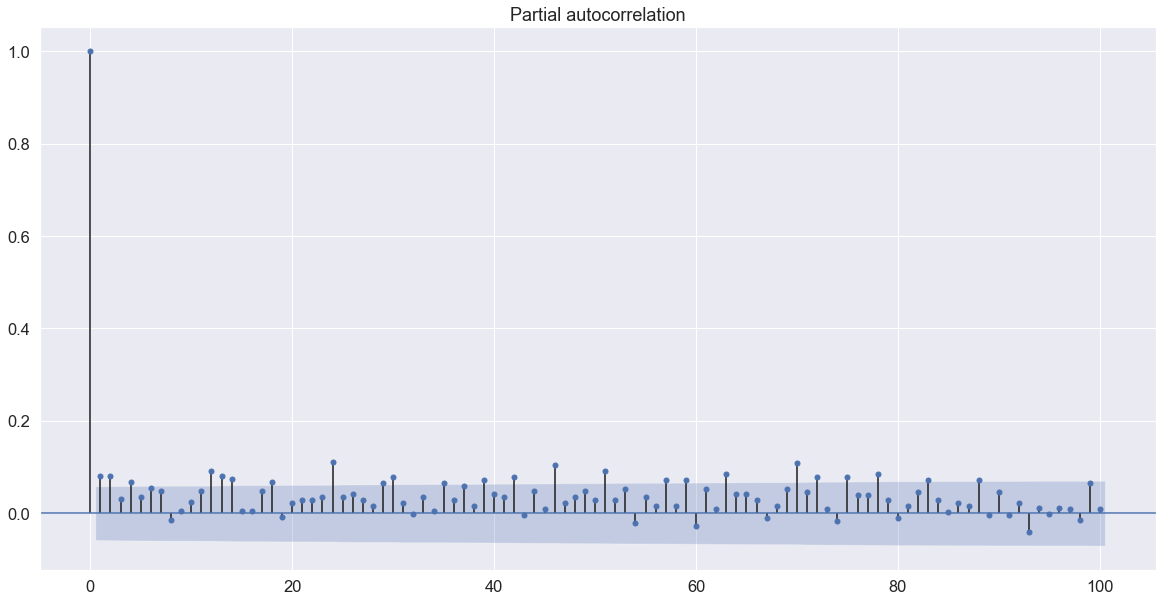

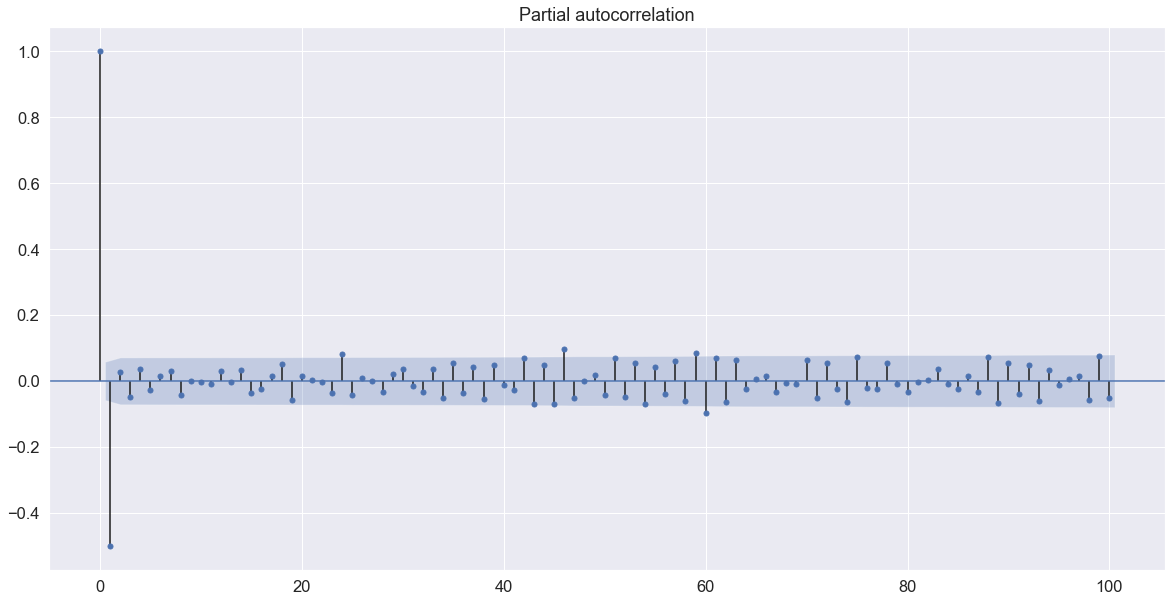

In [175]:
with plt.rc_context():
    plt.rc("figure", figsize=(20,10))
    product = 'HOBBIES_1_011_CA_1_validation'
    plot_acf(data[data['id'] == product]['demand'], ax=None, lags=100, alpha=0.01, use_vlines=True, title='Partial autocorrelation', zero=True)
    plot_acf(data[data['id'] == product]['demand'].diff(periods = 1)[1:], ax=None, lags=100, alpha=0.01, use_vlines=True, title='Partial autocorrelation', zero=True)

    
#plot_acf(data[data['id'] == 'HOBBIES_1_006_CA_1_validation']['demand'].diff(periods = 1)[1:], ax=None, lags=100, alpha=0.01, use_vlines=True, title='Partial autocorrelation', zero=True)
#plot_acf(data[data['id'] == 'HOBBIES_1_006_CA_1_validation']['demand'], ax=None, lags=100, alpha=0.01, use_vlines=True, title='Partial autocorrelation', zero=True)


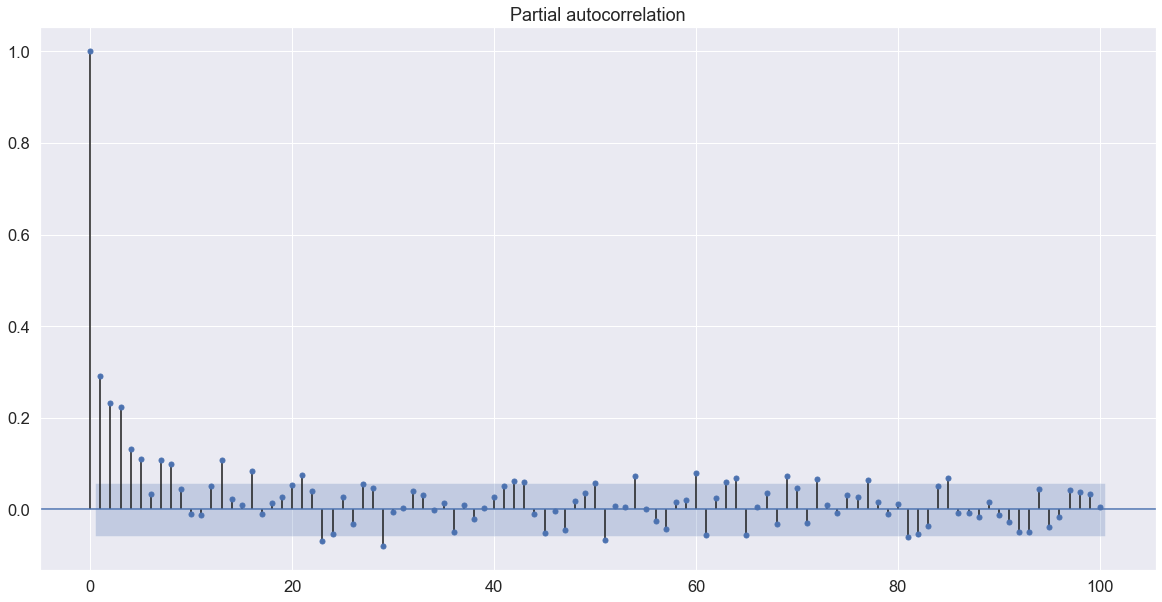

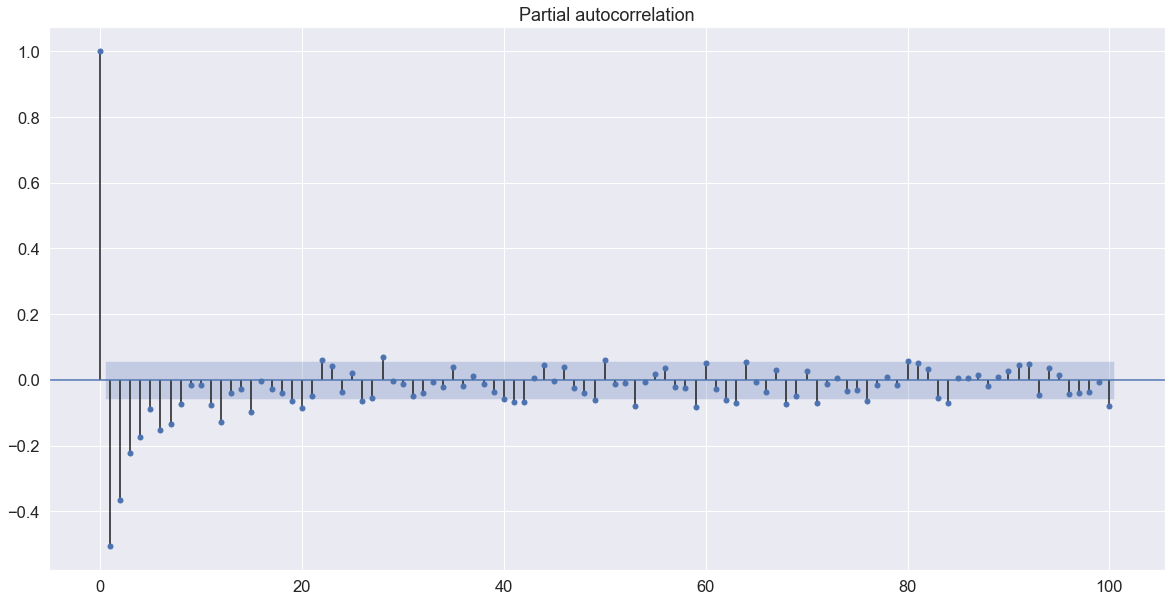

In [184]:
with plt.rc_context():
    plt.rc("figure", figsize=(20,10))
    product = 'HOBBIES_1_003_CA_1_validation'
    plot_pacf(data[data['id'] == product]['demand'], ax=None, lags=100, alpha=0.01, method= 'ldb', use_vlines=True, title='Partial autocorrelation', zero=True)
    plot_pacf(data[data['id'] == product]['demand'].diff(periods = 1)[1:], ax=None, lags=100, alpha=0.01, method= 'ldb', use_vlines=True, title='Partial autocorrelation', zero=True)

#plot_pacf(data[data['id'] == 'HOBBIES_1_006_CA_1_validation']['demand'].diff(periods = 1)[1:], ax=None, lags=100, alpha=0.01, method= 'ldb', use_vlines=True, title='Partial autocorrelation', zero=True)
#plot_pacf(data[data['id'] == 'HOBBIES_1_006_CA_1_validation']['demand'], ax=None, lags=100, alpha=0.01, method= 'ldb', use_vlines=True, title='Partial autocorrelation', zero=True)
